# Brain Tumor Segmentation with MONAI

A step-by-step guide to building a 2D brain tumor segmentation model using the MONAI framework.


## Workflow Overview

1. Prepare file lists for images and masks
2. Define MONAI transforms for preprocessing and augmentation
3. Create datasets and dataloaders (using `PersistentDataset` for speed)
4. Build a 2D U-Net model with MONAI
5. Set up loss function, optimizer, and learning rate scheduler
6. Train the model with validation, metrics, and checkpointing
7. Tips for fine-tuning (e.g., freezing layers, low learning rate, augmentations)


## 0. Imports

Import all required libraries and set up the environment.


In [ ]:
import os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchinfo import summary

from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord,
    RandFlipd, RandRotate90d, Compose, Resized
)
from monai.data import PersistentDataset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism

from tqdm import tqdm

set_determinism(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Frees unused memory held by the caching allocator
torch.cuda.empty_cache()  
device, torch.__version__

(device(type='cuda'), '2.6.0+cu126')

In [3]:
!nvidia-smi

Wed Aug 13 10:06:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P5             20W /  115W |     324MiB /   6144MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Prepare File Lists

Build lists of image and mask file paths, and split them into training and testing sets.


In [4]:
# Define paths to the image and mask directories
IMAGE_DIR = Path("brain_tumor_dataset/images")
MASK_DIR = Path("brain_tumor_dataset/masks")

# Get all image and mask file paths, assuming they are PNG files
images = list(IMAGE_DIR.glob("*.png"))
masks = list(MASK_DIR.glob("*.png"))

# Create a list of dictionaries, pairing each image with its corresponding mask.
# This assumes that the files in both directories are sorted in a corresponding order.
data_dicts = [
    {
        "image": img, 
        "mask": m
        
    } for img, m in zip(images, masks)
]

# --- Data Splitting ---
import random
# Set a random seed for reproducibility, ensuring the shuffle is the same every time.
random.seed(42) 
# Shuffle the data dictionaries in place to randomize the dataset.
random.shuffle(data_dicts)

# Calculate the split index for an 80/20 train-test split.
n_val = int(0.8 * len(data_dicts)) 
# Split the data into training and testing sets.
train_files = data_dicts[:n_val]
test_files = data_dicts[n_val:]

# Print a sample from each set to verify the structure.
print("Sample from training set:", train_files[5])
print("Sample from testing set:", test_files[5])
print (f"Length of training set: {len(train_files)}")
print (f"Length of testing set: {len(test_files)}")



Sample from training set: {'image': WindowsPath('brain_tumor_dataset/images/1041.png'), 'mask': WindowsPath('brain_tumor_dataset/masks/1041.png')}
Sample from testing set: {'image': WindowsPath('brain_tumor_dataset/images/1284.png'), 'mask': WindowsPath('brain_tumor_dataset/masks/1284.png')}
Length of training set: 2451
Length of testing set: 613


## 2. Define 2D Transforms

Set up preprocessing and augmentation transforms for both training and validation.


In [5]:
# Target size
target_size = (256, 256) # change if it doesn'tfit the GPU

# Define the sequence of transformations for the training data. These include data augmentation steps.
train_transforms = Compose([ 
    LoadImaged(keys=["image", "mask"]),           # Loads the image and mask data from the file paths specified in the dictionary.
    
    EnsureChannelFirstd(keys=["image", "mask"]),  # Ensures the data format is [Channel, Height, Width], which is standard for PyTorch.
    
    ScaleIntensityd(keys=["image"]),              # Normalizes the intensity values of the image (e.g., to a [0, 1] range). 
    
    Resized(keys=["image", "mask"],               # Resize all image to the same shape
            spatial_size=target_size),
    
    RandFlipd(keys=["image", "mask"],             # Randomly flips the image and mask for data augmentation.
                prob=0.5, spatial_axis=0),        # Flips along the first spatial axis (e.g., horizontal) with a 50% probability.
    
    RandRotate90d(keys=["image", "mask"],         # Randomly rotates the image and mask in 90-degree increments for augmentation.
                prob=0.5, max_k=3),               # Applies rotation with a 50% probability, up to 3 times (90, 180, or 270 degrees).
    
    ToTensord(keys=["image", "mask"]),            # Converts the image and mask from NumPy arrays to PyTorch Tensors.
])

# Define the sequence of transformations for the testing/validation data.
# Note: This pipeline does not include random augmentations (like flip or rotate) to ensure consistent evaluation.
test_transforms = Compose([ 
    LoadImaged(keys=["image", "mask"]),           # Loads the image and mask data from the file paths specified in the dictionary.
    
    EnsureChannelFirstd(keys=["image", "mask"]),  # Ensures the data format is [Channel, Height, Width].
    
    ScaleIntensityd(keys=["image"]),              # Normalizes the intensity values of the image.
    
    Resized(keys=["image", "mask"],               # Resize all image to the same shape
            spatial_size=target_size),
    
    ToTensord(keys=["image", "mask"]),            # Converts the image and mask from NumPy arrays to PyTorch Tensors.
])


train_transforms, test_transforms

(<monai.transforms.compose.Compose at 0x2b66edbbb20>,
 <monai.transforms.compose.Compose at 0x2b66e8567a0>)

## 3. Datasets and Dataloaders

Create MONAI datasets and PyTorch dataloaders for efficient data loading.


In [6]:
os.cpu_count(), os.cpu_count()//2

(16, 8)

In [13]:
# --- Create a directory for the persistent cache ---
# For best performance, ensure this directory is on a fast drive (like an NVMe SSD).
cache_dir = os.path.join(".", "persistent_cache") # Using a local folder
os.makedirs(cache_dir, exist_ok=True)

In [17]:
# --- Create MONAI Datasets and PyTorch DataLoaders ---

# Create a training dataset with caching.
train_DS = PersistentDataset(
    data=train_files,         # The list of file dictionaries for training.
    transform=train_transforms, # The transformations (including augmentations) to apply.
    cache_dir=os.path.join(cache_dir, "train") # Use a sub-directory for the training caches.
)

# Create a testing dataset. Caching is also beneficial here for faster repeated evaluations.
test_DS = PersistentDataset(
    data=test_files,          # The list of file dictionaries for testing.
    transform=test_transforms,  # The transformations (without augmentations) to apply.
    cache_dir=os.path.join(cache_dir, "test") # Use a sub-directory for the testing cache
)


# Create a DataLoader for the training set.
train_loader = DataLoader(
    dataset=train_DS,         # The dataset to load from.
    batch_size=8,             # Number of samples per batch.
    shuffle=True,             # Shuffle the data at the beginning of each epoch to improve model generalization.
    num_workers=os.cpu_count(),  # Use all available CPU cores to load data in parallel, preventing bottlenecks.
    pin_memory=True           # Speeds up data transfer from CPU to GPU by putting tensors in pinned memory.
)

# Create a DataLoader for the testing set.
test_loader = DataLoader(
    dataset=test_DS,          # The dataset to load from.
    batch_size=4,             # A smaller batch size for evaluation is common.
    shuffle=False,            # Do not shuffle the test data to ensure consistent and reproducible evaluation.
    num_workers=os.cpu_count()//2, # Use half the CPU cores for loading test data.
    pin_memory=True           # Speeds up data transfer from CPU to GPU by putting tensors in pinned memory.
)

In [18]:
train_DS, test_DS, train_loader, test_loader

(<monai.data.dataset.PersistentDataset at 0x2b6fea81660>,
 <torch.utils.data.dataloader.DataLoader at 0x2b6fea80a00>)

## 4. Model

Define a 2D U-Net model for segmentation using MONAI.


In [9]:
"""
The following code block initializes the U-Net model with specific parameters tailored for this brain tumor segmentation task.

U-Net Parameters Explained:
---------------------------
spatial_dims: Defines the dimensionality of the data. 
            For 2D MRI slices, this is 2. 
            For 3D MRI volumes, it would be 3.

in_channels: The number of input channels for the model. 
                For a single grayscale MRI slice, this is 1. 
                If using multi-modal data (like T1, T1ce, T2, FLAIR from BraTS), this would be 4.

out_channels: The number of output channels, which corresponds to the number of classes to be segmented. 
            For binary segmentation (tumor vs. background), this is 1.

channels: A tuple defining the number of feature channels at each level of the U-Net's encoder path. 
        The model starts with 16 channels, 
        then downsamples and increases the channel count to 32, 64, 128, and finally 256 at the bottleneck. 
        The decoder path will mirror this in reverse.

strides: A tuple defining the stride for the downsampling convolutions at each level of the encoder. 
        A stride of 2 halves the spatial dimensions (height and width) of the feature map at each step, which is standard for U-Nets.

num_res_units: The number of residual convolutional blocks at each level of the U-Net. 
            Using 2 units per level increases the model's capacity to learn complex features at different resolutions.
"""

# Set the number of classes for segmentation.
# For binary segmentation (tumor vs. background), this is 1.
num_classes = 1

# Set the number of input channels.
# Since we are using 2D grayscale MRI slices, this is 1.
in_channels = 1

# The number of output channels is equal to the number of classes.
out_channels = num_classes

model = UNet(
    spatial_dims=2,                 # Using 2D convolutions and operations.
    
    in_channels=in_channels,        # Number of channels in the input image.
    out_channels=out_channels,      # Number of channels in the output mask.
    
    channels=(16, 32, 64, 128, 256),# Feature maps at each level of the encoder.
    strides=(2, 2, 2, 2),           # Downsampling factor at each encoder level.
    
    num_res_units=2,                # Number of convolutional blocks per level.
).to(device) # Move the model to the specified device (GPU or CPU).



summary(
    model,
    # The input size should match the model's 2D configuration: (batch_size, channels, height, width)
    input_size=(1, in_channels, 224, 224),
    col_names=("input_size", "output_size", "num_params", "trainable"),
)



Layer (type:depth-idx)                                                                     Input Shape               Output Shape              Param #                   Trainable
UNet                                                                                       [1, 1, 224, 224]          [1, 1, 224, 224]          --                        True
├─Sequential: 1-1                                                                          [1, 1, 224, 224]          [1, 1, 224, 224]          --                        True
│    └─ResidualUnit: 2-1                                                                   [1, 1, 224, 224]          [1, 16, 112, 112]         --                        True
│    │    └─Conv2d: 3-1                                                                    [1, 1, 224, 224]          [1, 16, 112, 112]         160                       True
│    │    └─Sequential: 3-2                                                                [1, 1, 224, 224]          [1, 16, 

## 5. Loss Function and Optimizer

Set up the Dice loss, Adam optimizer, and a learning rate scheduler.


In [10]:
"""
This block sets up the core components for training the model: 
the loss function, 
the optimizer, 
and a learning rate scheduler.

- Loss Function (DiceLoss): Measures how well the model's prediction matches the 
  ground truth mask. 
  Dice Loss is particularly effective for segmentation tasks as 
  it focuses on the overlap between the predicted and actual regions, which is 
  robust to class imbalance (e.g., small tumors in a large image).

- Optimizer (Adam): The algorithm that updates the model's weights to minimize the loss.

- Scheduler (ReduceLROnPlateau): A strategy to dynamically adjust the learning 
  rate during training. It will "reduce" the learning rate when the model's 
  performance on the validation set "plateaus" (stops improving). This helps the 
  model to fine-tune its weights and escape local minima.
"""
# Define the loss function. DiceLoss is excellent for segmentation tasks.
# sigmoid=True is necessary as our model outputs raw logits. 
# It applies a sigmoid to the output before calculating loss.
loss_fn = DiceLoss(sigmoid=True)

# Define the optimizer.
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-4)

# Define a learning rate scheduler. 
# It will reduce the learning rate when the validation loss stops improving ('min' mode).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min', 
                                                        factor=0.1, 
                                                        patience=10, 
                                                        verbose=True)



## 6. Training Loop and Metrics

Configure training and validation loops, and initialize metrics for evaluation.


In [11]:
# Initialize the Dice Metric for evaluating segmentation performance.
# `include_background=False` means the background class (label 0) is ignored during calculation.
# `reduction="mean"` specifies that the Dice scores for all classes will be averaged.
metric = DiceMetric(include_background=False,
                    reduction= "mean")

# Set the total number of training epochs.
epochs = 20

# Initialize a variable to track the best validation Dice score achieved so far.
# This is used to save the best performing model checkpoint.
best_val_dice = 0.0

# Initialize a Gradient Scaler for Automatic Mixed Precision (AMP) training.
# This helps prevent underflow of gradients when using float16 precision,
# improving training stability and speed on compatible GPUs.
scaler = torch.amp.GradScaler(device = "cuda")

### 6.1 Detailed Training Loop (for explanation only)

_This cell explains the training loop step-by-step. Do not execute._


In [ ]:
# 1. Start the training loop
for epoch in range(epochs):
    print (f"Starting Epoch number = {epoch+1}")
    
    # 2. Set the model to training mode
    model.train()
    
    # 3. init the total loss for the current epoch
    epoch_loss = 0
    
    # 4. Loop over all batches of data in the training loader
    for batch in tqdm(train_loader, desc=f"Train E-{epoch+1}"):
        
        # 5. Load images and ground truth masks for the current batch
        # and move them to the specified computing device (e.g., "cuda" for GPU).
        # Move imgs and gts to the GPU asynchronously
        imgs = batch["image"].to(device, non_blocking=True)  # Input images (B, C, H, W)
        gts = batch["mask"].to(device, non_blocking=True)   # Ground truth masks (B, 1, H, W)
    
        # 6. Clear the gradients from the previous iteration
        # This is essential because PyTorch gradients are accumulated by default.
        optimizer.zero_grad()
        
        # 7. Use Automatic Mixed Precision (AMP) for training
        # This can speed up training and reduce memory usage on compatible hardware (NVIDIA GPUs).
        with torch.amp.autocast(device_type="cuda"):
            
            # 8. Forward pass: Get model predictions (logits) for the input images
            logits = model(imgs)  # (B, 1, H, W)
            
            # 9. Calculate the loss between the model's predictions and the ground truth
            loss = loss_fn(logits, gts)
            
        # 10. Backpropagation: Calculate gradients using the scaled loss
        # The GradScaler helps prevent gradients from becoming zero ("underflowing") when using float16 precision.
        scaler.scale(loss).backward()
        
        # 11. Update model weights
        # The scaler checks for invalid gradients (NaNs/Infs) and tells the optimizer to update the weights.
        scaler.step(optimizer)
        
        # 12. Update the GradScaler's scale factor for the next iteration
        scaler.update()
        
        # 13. Accumulate the loss for the current batch
        # .item() gets the scalar value from the loss tensor.
        epoch_loss += loss.item()
    
    # 14. Calculate the average loss for the entire epoch
    epoch_loss /= len(train_loader)
    
    # 15. Save the model checkpoint after the epoch
    checkpoint_path = os.path.join("checkpoints/", f"model_epoch_{epoch+1}.pth")
    # Saving the model's state_dict is the recommended practice for flexibility.
    torch.save(model.state_dict(), checkpoint_path)
    
    print(f"\nEpoch {epoch+1} Average Loss: {epoch_loss:.4f}")
    print(f"Checkpoint saved: {checkpoint_path}\n")



### 6.2 Detailed Validation Loop (for explanation only)

_This cell explains the validation loop step-by-step. Do not execute._


In [ ]:
# --- Start Validation Phase ---

# 1. Set the model to evaluation mode
model.eval()

# 2. Initialize a list to store the average Dice score for each batch
val_dice_scores = []

# 3. Use torch.inference_mode() to disable gradient calculations
with torch.inference_mode():
    
    # 4. Loop over all batches in the test_loader
    for batch_data in tqdm(test_loader, desc=f"Validation E-{epoch+1}"):
        
        # 5. Load images and masks for the current batch and move to the GPU
        #    - `non_blocking=True` allows for asynchronous data transfer, which can
        #      overlap with other computations and speed up the pipeline.
        test_img = batch_data["image"].to(device, non_blocking=True)
        test_gts = batch_data["mask"].to(device, non_blocking=True)
        
        # 6. Use Automatic Mixed Precision (AMP) for the forward pass
        #    - `autocast` automatically uses float16 for eligible operations, which
        #      speeds up inference and reduces GPU memory usage on compatible hardware.
        with torch.amp.autocast(device_type="cuda"):
            # Get the raw model outputs (logits)
            test_outputs = model(test_img)
            
            # 7. Convert logits to binary predictions
            #    - Apply the sigmoid function to squash outputs to a [0, 1] range (probabilities).
            #    - Threshold the probabilities at 0.5 to create a binary mask (0 or 1).
            #    - Convert the boolean mask to a float tensor for calculations.
            preds = (torch.sigmoid(test_outputs) > 0.5).float()
            
        # 8. Calculate the Dice score for each image in the batch
        #    - The Dice coefficient is a standard metric for segmentation tasks.
        #    - Formula: (2 * |A ∩ B|) / (|A| + |B|)
        #    - We sum over the channel, height, and width dimensions (1, 2, 3).
        #    - `1e-6` (epsilon) is added for numerical stability to avoid division by zero.
        intersection = (preds * test_gts).sum(dim=(1, 2, 3))
        union = preds.sum(dim=(1, 2, 3)) + test_gts.sum(dim=(1, 2, 3))
        dice_per_image = (2.0 * intersection + 1e-6) / (union + 1e-6)
        
        # 9. Append the mean Dice score of the batch to our list of scores
        #    - We take the mean of the Dice scores calculated for each image in the batch.
        #    - `.item()` extracts the scalar value from the tensor.
        val_dice_scores.append(dice_per_image.mean().item())

# 10. Calculate the final validation Dice score for the entire epoch
#     - This is the average of the mean Dice scores from all batches.
mean_val_dice = sum(val_dice_scores) / len(val_dice_scores)

# 11. Update the learning rate scheduler
#     - For schedulers like ReduceLROnPlateau, this adjusts the LR based on the
#       validation metric. We use (1.0 - Dice) because schedulers typically
#       monitor a value that should be minimized (like loss).
if scheduler:
    scheduler.step(1.0 - mean_val_dice)

# 12. Print a summary of the epoch's performance
print(f"\n--- Epoch {epoch+1} Summary ---")
print(f"  Train Loss: {epoch_loss:.4f}")
print(f"  Validation Dice: {mean_val_dice:.4f}")



### 6.3 Training and Validation as Functions

Refactor the training and validation logic into reusable functions.


In [23]:
# ======================================================================================
# 1. DEFINE THE TRAINING FUNCTION FOR ONE EPOCH
# ======================================================================================
def train_one_epoch(model, loader, optimizer, loss_fn, scaler, device, epoch_num):
    """
    Performs one full training epoch.
    
    Args:
        model (torch.nn.Module): The model to be trained.
        loader (DataLoader): The DataLoader for the training data.
        optimizer (torch.optim.Optimizer): The optimizer for updating weights.
        loss_fn: The loss function.
        scaler (torch.cuda.amp.GradScaler): The gradient scaler for mixed precision.
        device (torch.device): The device to train on (e.g., "cuda").
        epoch_num (int): The current epoch number, for logging.
        
    Returns:
        float: The average training loss for the epoch.
    """
    # Set the model to training mode
    model.train()
    
    epoch_loss = 0.0
    progress_bar = tqdm(loader, desc=f"Train E-{epoch_num}")
    
    for batch in progress_bar:
        # Move data to the target device asynchronously
        imgs = batch["image"].to(device, non_blocking=True)
        gts = batch["mask"].to(device, non_blocking=True)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass with Automatic Mixed Precision (AMP)
        with torch.amp.autocast(device_type="cuda"):
            logits = model(imgs)
            loss = loss_fn(logits, gts)
            
        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Accumulate loss and update progress bar
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    # Return the average loss for the epoch
    return epoch_loss / len(loader)

In [ ]:
def evaluate(model, loader, device, epoch_num):
    """
    Evaluates the model on the validation set.
    
    Args:
        model (torch.nn.Module): The model to be evaluated.
        loader (DataLoader): The DataLoader for the validation data.
        device (torch.device): The device to evaluate on.
        epoch_num (int): The current epoch number, for logging.
        
    Returns:
        tuple[float, float]: A tuple containing the average validation Dice score
                            and the average validation accuracy.
    """
    # Set the model to evaluation mode
    model.eval()
    
    val_dice_scores = []
    val_acc = []
    progress_bar = tqdm(loader, desc=f"Validation E-{epoch_num}")
    
    # Disable gradient calculations for efficiency
    with torch.inference_mode():
        for batch_data in progress_bar:
            # Move data to the target device
            test_img = batch_data["image"].to(device, non_blocking=True)
            test_gts = batch_data["mask"].to(device, non_blocking=True)
            
            # Forward pass with AMP
            with torch.amp.autocast(device_type="cuda"):
                test_outputs = model(test_img)
                preds = (torch.sigmoid(test_outputs) > 0.5).float()
                # binarize your ground truth before computing Dice:
                test_gts = (test_gts > 0.5).float()

            # Calculate Dice score for the batch
            intersection = (preds * test_gts).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + test_gts.sum(dim=(1, 2, 3))
            dice_per_image = (2.0 * intersection + 1e-6) / (union + 1e-6)
            batch_dice = dice_per_image.mean().item()
            
            # Calculate pixel-wise accuracy for the batch
            # - Accuracy = (Correctly classified pixels) / (Total pixels)
            correct_pixels = (preds == test_gts).sum()
            total_pixels = test_gts.numel() # Total number of pixels in the batch
            batch_accuracy = (correct_pixels / total_pixels).item()
            
            # Store the mean dice score for the batch
            val_dice_scores.append(batch_dice)
            val_acc.append(batch_accuracy)
            progress_bar.set_postfix(dice=batch_dice, acc=batch_accuracy)
            
    # Return the average Dice and Accuracy scores across all validation batches
    mean_dice = sum(val_dice_scores) / len(val_dice_scores)
    mean_accuracy = sum(val_acc) / len(val_acc)
    return mean_dice, mean_accuracy

In [26]:
for epoch in range(1, epochs + 1):
    print(f"\n===== Starting Epoch {epoch}/{epochs} =====")
    
    # Run the training function
    train_loss = train_one_epoch(model,
                                train_loader, 
                                optimizer, 
                                loss_fn, 
                                scaler, 
                                device, 
                                epoch)
    
    # Run the evaluation function
    val_dice, val_acc = evaluate(model, 
                                test_loader, 
                                device, 
                                epoch)
    
    # Update the learning rate scheduler based on the validation metric
    if scheduler:
        # We use (1.0 - Dice) because schedulers typically monitor a value to be minimized
        scheduler.step(1.0 - val_dice)
        
    # Save the model checkpoint
    checkpoint_path = os.path.join("checkpoints/", f"model_epoch_{epoch}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    
    # Print a summary of the epoch's performance
    print(f"\n--- Epoch {epoch} Summary ---")
    print(f"  Train Loss:      {train_loss:.4f}")
    print(f"  Validation Dice:   {val_dice:.4f}")
    print(f"  Validation Acc:    {val_acc*100:.4f}")
    print(f"  Checkpoint saved:  {checkpoint_path}")
    print("=" * (35 + len(str(epoch)) + len(str(epochs))))

print("\nTraining finished!")


===== Starting Epoch 1/20 =====


Validation E-1: 100%|██████████| 154/154 [00:24<00:00,  6.35it/s, acc=0.855, dice=1.91]



--- Epoch 1 Summary ---
  Train Loss:      -0.8249
  Validation Dice:   1.8366
  Validation Acc:    84.7002
  Checkpoint saved:  checkpoints/model_epoch_1.pth

===== Starting Epoch 2/20 =====


Validation E-2: 100%|██████████| 154/154 [00:24<00:00,  6.32it/s, acc=0.862, dice=1.91]



--- Epoch 2 Summary ---
  Train Loss:      -0.8399
  Validation Dice:   1.8618
  Validation Acc:    87.4591
  Checkpoint saved:  checkpoints/model_epoch_2.pth

===== Starting Epoch 3/20 =====


Validation E-3: 100%|██████████| 154/154 [00:24<00:00,  6.24it/s, acc=0.87, dice=1.92] 



--- Epoch 3 Summary ---
  Train Loss:      -0.8400
  Validation Dice:   1.8481
  Validation Acc:    86.2800
  Checkpoint saved:  checkpoints/model_epoch_3.pth

===== Starting Epoch 4/20 =====


Validation E-4: 100%|██████████| 154/154 [00:23<00:00,  6.43it/s, acc=0.847, dice=1.9] 



--- Epoch 4 Summary ---
  Train Loss:      -0.8377
  Validation Dice:   1.8284
  Validation Acc:    82.9685
  Checkpoint saved:  checkpoints/model_epoch_4.pth

===== Starting Epoch 5/20 =====


Validation E-5: 100%|██████████| 154/154 [00:25<00:00,  6.08it/s, acc=0.853, dice=1.91]



--- Epoch 5 Summary ---
  Train Loss:      -0.8398
  Validation Dice:   1.8385
  Validation Acc:    82.9726
  Checkpoint saved:  checkpoints/model_epoch_5.pth

===== Starting Epoch 6/20 =====


Validation E-6: 100%|██████████| 154/154 [00:26<00:00,  5.87it/s, acc=0.892, dice=1.9] 



--- Epoch 6 Summary ---
  Train Loss:      -0.8546
  Validation Dice:   1.8732
  Validation Acc:    88.8233
  Checkpoint saved:  checkpoints/model_epoch_6.pth

===== Starting Epoch 7/20 =====


Validation E-7: 100%|██████████| 154/154 [00:23<00:00,  6.62it/s, acc=0.863, dice=1.91]



--- Epoch 7 Summary ---
  Train Loss:      -0.8591
  Validation Dice:   1.8391
  Validation Acc:    86.3476
  Checkpoint saved:  checkpoints/model_epoch_7.pth

===== Starting Epoch 8/20 =====


Validation E-8: 100%|██████████| 154/154 [00:23<00:00,  6.49it/s, acc=0.884, dice=1.93]



--- Epoch 8 Summary ---
  Train Loss:      -0.8608
  Validation Dice:   1.8627
  Validation Acc:    86.3803
  Checkpoint saved:  checkpoints/model_epoch_8.pth

===== Starting Epoch 9/20 =====


Validation E-9: 100%|██████████| 154/154 [00:24<00:00,  6.32it/s, acc=0.887, dice=1.93]



--- Epoch 9 Summary ---
  Train Loss:      -0.8637
  Validation Dice:   1.8784
  Validation Acc:    88.5619
  Checkpoint saved:  checkpoints/model_epoch_9.pth

===== Starting Epoch 10/20 =====


Validation E-10: 100%|██████████| 154/154 [00:24<00:00,  6.36it/s, acc=0.889, dice=1.93]



--- Epoch 10 Summary ---
  Train Loss:      -0.8658
  Validation Dice:   1.8622
  Validation Acc:    87.6556
  Checkpoint saved:  checkpoints/model_epoch_10.pth

===== Starting Epoch 11/20 =====


Validation E-11: 100%|██████████| 154/154 [00:23<00:00,  6.56it/s, acc=0.863, dice=1.91]



--- Epoch 11 Summary ---
  Train Loss:      -0.8702
  Validation Dice:   1.8698
  Validation Acc:    87.6570
  Checkpoint saved:  checkpoints/model_epoch_11.pth

===== Starting Epoch 12/20 =====


Validation E-12: 100%|██████████| 154/154 [00:24<00:00,  6.39it/s, acc=0.899, dice=1.94]



--- Epoch 12 Summary ---
  Train Loss:      -0.8752
  Validation Dice:   1.8800
  Validation Acc:    89.6552
  Checkpoint saved:  checkpoints/model_epoch_12.pth

===== Starting Epoch 13/20 =====


Validation E-13: 100%|██████████| 154/154 [00:23<00:00,  6.58it/s, acc=0.921, dice=1.95]



--- Epoch 13 Summary ---
  Train Loss:      -0.8722
  Validation Dice:   1.8778
  Validation Acc:    89.2228
  Checkpoint saved:  checkpoints/model_epoch_13.pth

===== Starting Epoch 14/20 =====


Validation E-14: 100%|██████████| 154/154 [00:22<00:00,  6.95it/s, acc=0.91, dice=1.94] 



--- Epoch 14 Summary ---
  Train Loss:      -0.8808
  Validation Dice:   1.8848
  Validation Acc:    90.1186
  Checkpoint saved:  checkpoints/model_epoch_14.pth

===== Starting Epoch 15/20 =====


Validation E-15: 100%|██████████| 154/154 [00:23<00:00,  6.49it/s, acc=0.91, dice=1.94] 



--- Epoch 15 Summary ---
  Train Loss:      -0.8866
  Validation Dice:   1.8852
  Validation Acc:    90.5764
  Checkpoint saved:  checkpoints/model_epoch_15.pth

===== Starting Epoch 16/20 =====


Validation E-16: 100%|██████████| 154/154 [00:24<00:00,  6.39it/s, acc=0.922, dice=1.95]



--- Epoch 16 Summary ---
  Train Loss:      -0.8912
  Validation Dice:   1.8873
  Validation Acc:    90.5535
  Checkpoint saved:  checkpoints/model_epoch_16.pth

===== Starting Epoch 17/20 =====


Validation E-17: 100%|██████████| 154/154 [00:23<00:00,  6.54it/s, acc=0.93, dice=1.96] 



--- Epoch 17 Summary ---
  Train Loss:      -0.8915
  Validation Dice:   1.8844
  Validation Acc:    90.8224
  Checkpoint saved:  checkpoints/model_epoch_17.pth

===== Starting Epoch 18/20 =====


Validation E-18: 100%|██████████| 154/154 [00:22<00:00,  6.99it/s, acc=0.929, dice=1.95]



--- Epoch 18 Summary ---
  Train Loss:      -0.8903
  Validation Dice:   1.8885
  Validation Acc:    89.8967
  Checkpoint saved:  checkpoints/model_epoch_18.pth

===== Starting Epoch 19/20 =====


Validation E-19: 100%|██████████| 154/154 [00:27<00:00,  5.57it/s, acc=0.892, dice=1.93]



--- Epoch 19 Summary ---
  Train Loss:      -0.8972
  Validation Dice:   1.8668
  Validation Acc:    87.1146
  Checkpoint saved:  checkpoints/model_epoch_19.pth

===== Starting Epoch 20/20 =====


Validation E-20: 100%|██████████| 154/154 [00:24<00:00,  6.25it/s, acc=0.924, dice=1.95]


--- Epoch 20 Summary ---
  Train Loss:      -0.8973
  Validation Dice:   1.8940
  Validation Acc:    90.8133
  Checkpoint saved:  checkpoints/model_epoch_20.pth

Training finished!


## 7. Plot loss and accuracy curves

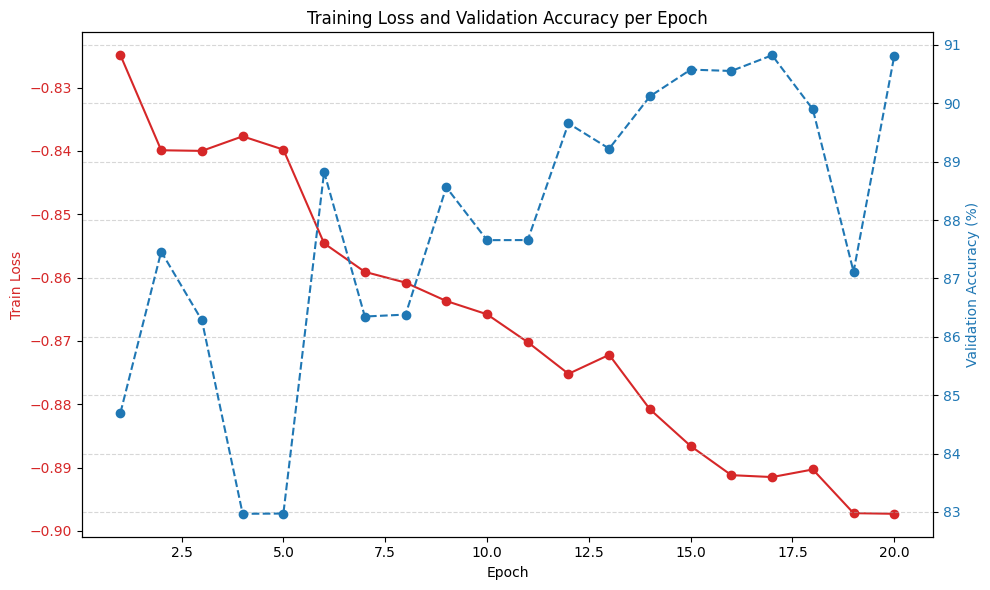

In [27]:
import matplotlib.pyplot as plt

# Data extracted from the logs (because i forgot to save them before starting training)
epochs = list(range(1, 21))
train_loss = [
    -0.8249, -0.8399, -0.8400, -0.8377, -0.8398,
    -0.8546, -0.8591, -0.8608, -0.8637, -0.8658,
    -0.8702, -0.8752, -0.8722, -0.8808, -0.8866,
    -0.8912, -0.8915, -0.8903, -0.8972, -0.8973
]
val_acc = [
    84.7002, 87.4591, 86.2800, 82.9685, 82.9726,
    88.8233, 86.3476, 86.3803, 88.5619, 87.6556,
    87.6570, 89.6552, 89.2228, 90.1186, 90.5764,
    90.5535, 90.8224, 89.8967, 87.1146, 90.8133
]

# Create plots
fig, ax1 = plt.subplots(figsize=(10, 6))

color_loss = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color_loss)
ax1.plot(epochs, train_loss, marker='o', color=color_loss, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color_loss)

# Twin axis for validation accuracy
ax2 = ax1.twinx()
color_acc = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (%)', color=color_acc)
ax2.plot(epochs, val_acc, marker='o', linestyle='--', color=color_acc, label='Val Accuracy')
ax2.tick_params(axis='y', labelcolor=color_acc)

# Title and grid
plt.title('Training Loss and Validation Accuracy per Epoch')
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
